In [447]:
# API
import requests
import json

# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

### Evapotranspiration data from 1959-01-01 to 2022-01-01

In [448]:
# Mango farm in Spain (Finca Los Pepenos)
# lat = 36.80
# long = -4.19

# Shepparton, Australia
lat = -36.38
long = 145.41

# Daily weather parameters
daily_params = ["et0_fao_evapotranspiration"]

# Timezone
timezone = "auto"

# Forecast period
start_date = "1959-01-01"
end_date = "2022-12-31"

# All params
params = {"latitude": lat, "longitude": long, 
          "daily": daily_params, "timezone": timezone,
          "start_date": start_date, "end_date": end_date}

# Default API url
api_url = "https://archive-api.open-meteo.com/v1/archive"

# API call
response = requests.get(api_url, params = params)

# Load the Data
data_units = response.json()["daily_units"]
data = pd.DataFrame(response.json()["daily"])
data.columns = ["date", "et"]

# Save .csv
data.to_csv("et.csv", index = False)

data

,date,et
0,1959-01-01,NaN
1,1959-01-02,6.66
2,1959-01-03,6.31
3,1959-01-04,7.26
4,1959-01-05,6.70
...,...,...
23371,2022-12-27,8.38
23372,2022-12-28,4.82
23373,2022-12-29,6.50
23374,2022-12-30,4.67


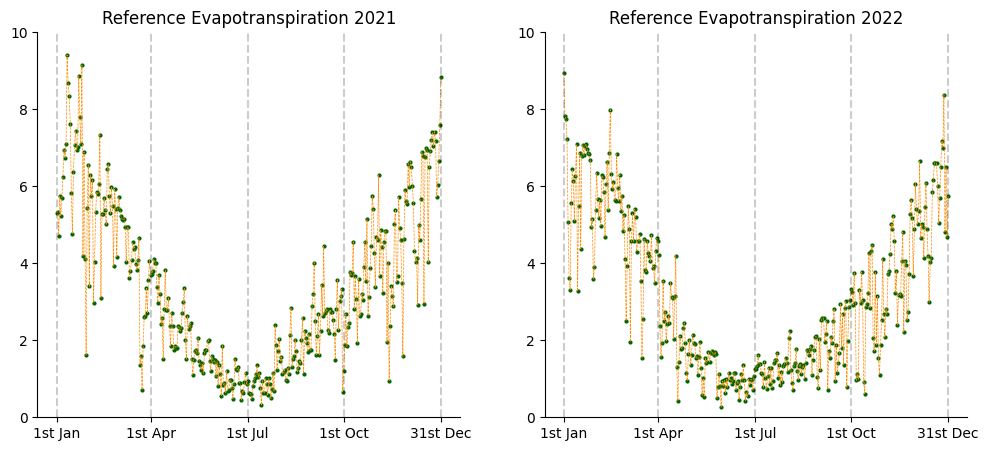

In [451]:
# Extract data for 2021, 2022
df21 = data[-365*2:-365]
df22 = data[-365:]

# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

def plotRefEt(ax, et, year):
    # Ticks
    ticks = [0, 89, 181, 272, 364]
    tick_labels = ["1st Jan", "1st Apr", "1st Jul", "1st Oct", "31st Dec"]

    # Plot
    ax.scatter(range(len(et)), et, s = 4, c = "darkgreen")
    ax.plot(range(len(et)), et, lw = 0.5, ls = "--", c = 'darkorange')
    ax.set_ylim(0, 10)
    ax.set_xticks(ticks, labels = tick_labels)
    for i in ticks:
        ax.axvline(i, c = "black", alpha = 0.2, ls = '--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f"Reference Evapotranspiration {year}")
    
plotRefEt(ax1, df21.et, "2021")
plotRefEt(ax2, df22.et, "2022")

plt.show()

### Entire available dataset of Evapotranspiration

In [452]:
# Set date as index
data["date"] = pd.to_datetime(data["date"], format= "%Y-%m-%d")
data = data.set_index("date")

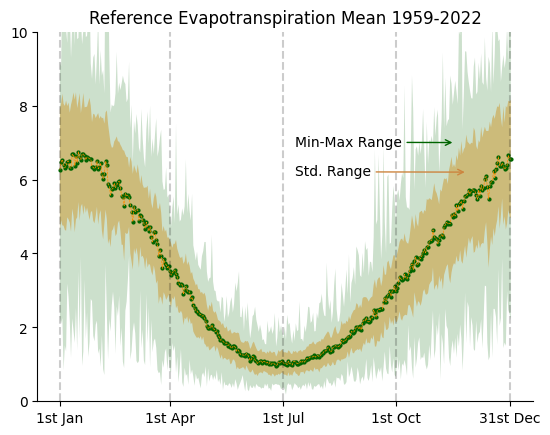

In [458]:
refEtMean = data.groupby([(data.index.month), (data.index.day)]).mean()
refEtStd = data.groupby([(data.index.month), (data.index.day)]).std()

# Initialize figure
fig, ax = plt.subplots(1, 1)

# Plot Std
ax.fill_between(range(366), refEtMean.et + refEtStd.et, refEtMean.et - refEtStd.et, 
                alpha = 0.4, color = "darkorange", edgecolor = None)

# Plot Min-Max
ax.fill_between(range(366), 
                data.groupby([(data.index.month), (data.index.day)]).max().et, 
                data.groupby([(data.index.month), (data.index.day)]).min().et, 
                alpha = 0.2, color = "darkgreen", edgecolor = None)

# Plot mean
plotRefEt(ax, refEtMean.et, "Mean 1959-2022")

# Annotate
ax.annotate("Min-Max Range", xy = (320, 7), xytext = (190, 6.9),
            arrowprops = {"arrowstyle": "->", "color": "darkgreen"})
ax.annotate("Std. Range", xy = (330, 6.2), xytext = (190, 6.1),
            arrowprops = {"arrowstyle": "->", "color": "peru"})

plt.show()

### Smoothing out the Data with Fourier Transform
A time series $x$ can be transformed into its *Fourier Series* $f(x)$ as
$$
f(x) = \sum_{k =0}^Ka_k\cos(k\cdot w\cdot x) + b_k\sin(k\cdot w\cdot x)
$$
where $x$ is our original data, $w$ is the period over which we expect the signal to repeat, and $K$ is the granularity of our approximation. When $k=0$ the expression reduces to $a_0$. General form for $w$ is $w = \frac{2\pi}{days}$.

In [459]:
# code adjusted from: https://stackoverflow.com/questions/52524919/fourier-series-fit-in-python

def fourier_curve_fit(ser, no_fourier = 3, display_latex = True, series = False):
    """
    Apply fourier curve fitting to series.

    ser: pandas.Series
    Contains data stored in Series.

    no_fourier: int
    degree of fourier series to be used.

    Returns
    pandas.Series
    """

    from IPython.display import display, Math

    ser_ = ser.reset_index(drop = True)
    x = ser_.index
    y = ser_.values

    A = (2 / len(y)) * np.matmul(y.reshape(1,-1),
                                 np.array([np.cos(2 * np.pi / len(y) * n * np.arange(len(y))) 
                                           for n in np.arange(no_fourier + 1)]).T).flatten()

    B = (2 / len(y)) * np.matmul(y.reshape(1,-1),
                                 np.array([np.sin(2 * np.pi / len(y) * n * np.arange(len(y))) 
                                           for n in np.arange(no_fourier + 1)]).T).flatten()

    L = max(x) - min(x)

    if display_latex:
        Omega = '\\frac{{2*\\pi}}{'+str(L)+'}'

        fourier_equation = ''

        for i,(a, b) in enumerate(zip(A, B)):
            if i == 0:
                fourier_equation += f'f(x)={a:.4f} \\\\'
            else:
                fourier_equation += f' {a:+.4f}*\\cos({Omega}*{i}*x) {b:+.4f}*\\sin({Omega}*{i}*x) \\\\'

        display(Math(fourier_equation))

    coeff = dict([(f'a{i}', j) for i, j in enumerate(A)] + [(f'b{i}', j) for i, j in enumerate(B)])

    if series:      
        As = np.matmul(A.reshape(1,-1), 
                       np.array([np.cos(2 * np.pi / len(y) * n * np.arange(len(y))) 
                                 for n in np.arange(no_fourier + 1)])).flatten()
        Bs = np.matmul(B.reshape(1,-1), 
                       np.array([np.sin(2 * np.pi/len(y) * n * np.arange(len(y))) 
                                 for n in np.arange(no_fourier + 1)])).flatten()
        
        return pd.Series(data = (As + Bs), index = ser.index, name = 'Fourier Fitted') - coeff['a0'] / 2
    else:
        return pd.Series(data = coeff, name = 'Fourier Coefficients')

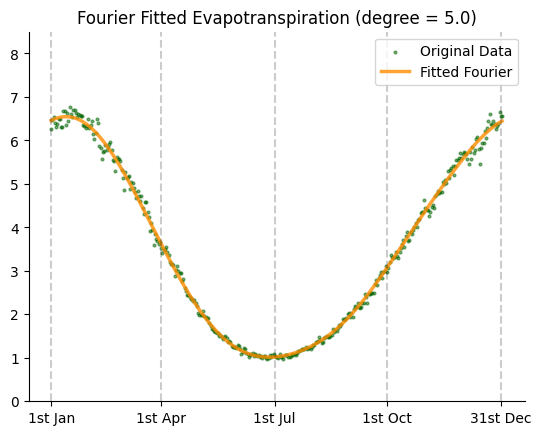

In [473]:
f_series = fourier_curve_fit(refEtMean.et, no_fourier = 4, display_latex = False, series = True)
f_series_coeffs = fourier_curve_fit(refEtMean.et, no_fourier = 4, display_latex = False, series = False)

# Initialize figure
fig, ax = plt.subplots(1, 1)

def plotFourierEt(ax, et, degree, **args):
    # Ticks
    ticks = [0, 89, 181, 272, 364]
    tick_labels = ["1st Jan", "1st Apr", "1st Jul", "1st Oct", "31st Dec"]

    # Plot
    ax.plot(range(len(et)), et, lw = 2.5, ls = "-", c = 'darkorange', alpha = 0.8, **args)
    ax.set_ylim(0, 8.5)
    ax.set_xticks(ticks, labels = tick_labels)
    for i in ticks:
        ax.axvline(i, c = "black", alpha = 0.2, ls = '--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f"Fourier Fitted Evapotranspiration (degree = {degree})")
    
# Plot Fitted Fourier Series
ax.scatter(range(len(refEtMean.et)), refEtMean.et, s = 4, c = "darkgreen", alpha = 0.5, label = "Original Data")
plotFourierEt(ax, f_series, len(f_series_coeffs)/2, label = "Fitted Fourier")
ax.legend(loc = "upper right")

# Save .csv
data.to_csv("fourierEt.csv", index = False)

### Attempt at fitting Fourier Series by SciPy's `curve_fit`

In [462]:
f_series_coeffs

a0    7.050483
a1    2.737875
a2    0.203620
a3   -0.021232
a4    0.012529
b0    0.000000
b1    0.195145
b2    0.215486
b3    0.040798
b4    0.016968
Name: Fourier Coefficients, dtype: float64

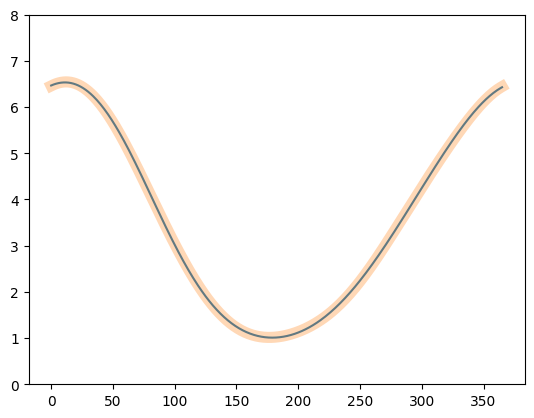

In [479]:
from scipy.optimize import curve_fit

# Define the Fourier's expansion
def FourierSeries(x, *params):
    a0 = params[0]
    p = params[1]
    n = int(len(params[2:])/2)
    a = params[2:2+n]
    b = params[2+n:]
    
    fx = a0 + sum([a[i] * np.cos(i * p * x) + b[i] * np.sin(i * p * x) for i in range(1, n)])
    return fx

# Create data
et = np.array(refEtMean.et)
xdata = range(len(et))
ydata = et

# Fit the curve using good starting point values for the parameters
# Without good starting point the result fails to converge, 
# or it seems that at least some params need to be well initialized

p0 = [np.mean(et) * 2, 2*np.pi/365, -2, 0.1, -0.03, 0, -0.05, 0.2, 0, 0]
popt, pcov = curve_fit(FourierSeries, xdata, ydata, maxfev = 10000, 
                       p0 = [np.mean(et) * 2, 2*np.pi, 0, 0, 0, 0, 0, 0.1, 0, 0])

fx = FourierSeries(xdata, *popt)
plt.plot(fx)
plt.plot(np.array(f_series), alpha = 0.3, lw = 8)
plt.ylim(0, 8)
plt.show()